In [1]:
import pickle
import numpy as np

with open("train_qa.txt", "rb")as fp:
    train_data = pickle.load(fp)

# train_data

with open("test_qa.txt", "rb")as fp:
    test_data = pickle.load(fp)

# test_data

In [2]:
print(len(test_data))
print(len(train_data))

# train_data[0]

#story
' '.join(train_data[0][1])

#question
' '.join(train_data[0][0])

#Answer
train_data[0][2]

vocab = set()

all_data = test_data + train_data

# all_data

# len(all_data)

#all_data

for story,question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

vocab.add('yes')
vocab.add('no')

# vocab

# len(vocab)

vocab_len = len(vocab)+1

for data in all_data:
    print(len(data[0]))

max_story_len=max([len(data[0])for data in all_data])
# max_story_len
    

max_ques_len=max([len(data[1])for data in all_data])
# max_ques_len

# vocab

1000
10000
12
23
35
47
59
13
26
37
50
62
12
24
37
49
60
12
25
38
50
62
12
24
36
47
59
12
25
36
48
59
12
26
39
51
63
13
24
37
50
62
13
26
38
50
63
13
25
36
49
61
13
26
39
51
64
13
25
37
50
62
13
25
37
50
61
12
25
38
50
62
12
25
37
50
61
12
25
36
48
60
12
24
36
48
60
13
25
37
49
60
13
25
39
51
64
12
25
37
49
61
12
25
38
50
61
12
24
36
49
62
13
25
37
50
62
12
23
35
47
59
12
25
37
48
73
12
24
37
49
61
12
24
37
49
62
14
26
37
49
62
12
23
35
48
59
12
24
36
49
61
13
25
37
49
61
12
25
37
50
62
12
24
36
47
58
12
24
36
48
61
25
38
50
62
74
13
25
37
49
62
12
24
37
49
62
12
24
36
48
60
12
24
36
48
61
12
25
36
50
62
24
36
49
61
74
12
24
36
47
59
13
25
38
50
62
12
25
37
49
61
12
24
36
48
61
13
25
37
48
61
13
26
39
52
63
13
27
40
51
63
12
24
36
48
59
12
24
36
47
58
12
23
35
47
59
12
25
38
50
62
12
24
35
47
60
13
26
38
51
63
12
24
36
48
61
12
24
36
48
60
13
25
38
49
62
12
24
35
47
59
12
24
36
48
58
12
24
36
48
61
13
26
38
50
63
24
37
49
62
74
12
24
36
49
61
13
26
39
51
63
12
24
36
48
60
12
24
36
47
59

In [3]:
#to vectorize data we should use the keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [4]:

tokenizer = Tokenizer(filters = [])

tokenizer.fit_on_texts(vocab)

# tokenizer.word_index

train_story_text = []
train_question_text = []
train_answers = []

for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

train_story_seq = tokenizer.texts_to_sequences(train_story_text)

# len(train_story_text)

# len(train_story_seq)

# train_story_text

# train_story_seq

def vectorize_stories(data, word_index=tokenizer.word_index, 
                      max_story_len=max_story_len, max_ques_len=max_ques_len):
    X = []
    Xq = []
    Y = []

    for story, query, answer in data:
        x = [word_index.get(word.lower(), 0) for word in story]
        xq = [word_index.get(word.lower(), 0) for word in query]
        
        if answer:
            y = np.zeros(len(word_index) + 1)
            y[word_index[answer]] = 1
        else:
            y = np.zeros(len(word_index) + 1)
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)

    return (
        pad_sequences(X, maxlen=max_story_len),
        pad_sequences(Xq, maxlen=max_ques_len),
        np.array(Y)
    )


inputs_train, queries_train, answers_train = vectorize_stories(train_data)

# inputs_train

inputs_test, queries_test, answers_test = vectorize_stories(test_data)

# answers_test

tokenizer.word_index['yes']

tokenizer.word_index['no']

32

In [5]:
##___________________________________________________________________________________________________________________________

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Dense, Input, add, dot, concatenate, Permute,LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Activation


# set max_ques_len to the maximum question sequence length in the training and testing data
max_ques_len = max(max(len(q) for (_, q, _) in train_data), max(len(q) for (_, q, _) in test_data))

inputs_train, queries_train, answers_train = vectorize_stories(train_data, max_ques_len=max_ques_len)
inputs_test, queries_test, answers_test = vectorize_stories(test_data, max_ques_len=max_ques_len)

# pad the inputs and queries to max_story_len and max_ques_len
inputs_train = pad_sequences(inputs_train, maxlen=max_story_len)
queries_train = pad_sequences(queries_train, maxlen=max_ques_len)
inputs_test = pad_sequences(inputs_test, maxlen=max_story_len)
queries_test = pad_sequences(queries_test, maxlen=max_ques_len)

# define the model architecture
input_sequence = Input((max_story_len,))
question = Input((max_ques_len,))

input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len, output_dim=64))
input_encoder_m.add(Dropout(0.3))

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len, output_dim=max_ques_len))
input_encoder_c.add(Dropout(0.3))

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len, output_dim=64, input_length=max_ques_len))
question_encoder.add(Dropout(0.3))

input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

answer = concatenate([response, question_encoded])

answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer)
answer = Activation('softmax')(answer)

model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# train the model
history = model.fit([inputs_train, queries_train], answers_train,
                    batch_size=32,
                    epochs=150,
                    validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/150
313/313 [==============================] - 10s 21ms/step - loss: 0.9112 - accuracy: 0.4963 - val_loss: 0.6947 - val_accuracy: 0.5030
Epoch 2/150
313/313 [==============================] - 6s 19ms/step - loss: 0.7080 - accuracy: 0.4949 - val_loss: 0.6943 - val_accuracy: 0.4970
Epoch 3/150
313/313 [==============================] - 5s 17ms/step - loss: 0.6984 - accuracy: 0.4972 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 4/150
313/313 [==============================] - 8s 26ms/step - loss: 0.6965 - accuracy: 0.4963 - val_loss: 0.6945 - val_accuracy: 0.4970
Epoch 5/150
313/313 [==============================] - 7s 22ms/step - loss: 0.6956 - accuracy: 0.4983 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 6/150
313/313 [==============================] - 9s 27ms/step - loss: 0.6952 - accuracy: 0.5054 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 7/150
313/313 [==============================] - 6s 20ms/step - loss: 0.6960 - accuracy: 0.4861 - val_loss: 0.6932 - val_accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 0, 'epochs')

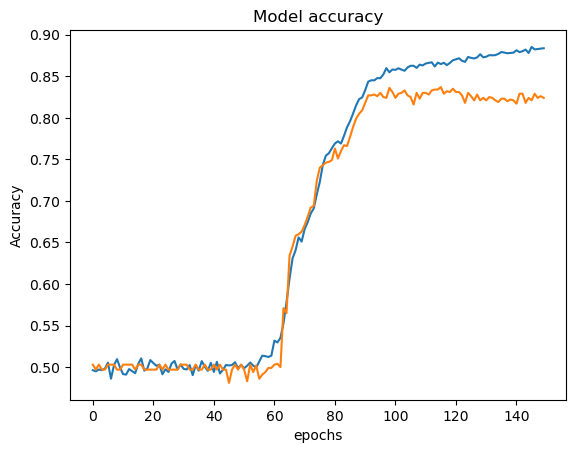

In [7]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel('Accuracy')
plt.xlabel("epochs")

In [8]:
#save the model
model.save("chatbot_model")

INFO:tensorflow:Assets written to: chatbot_model\assets


INFO:tensorflow:Assets written to: chatbot_model\assets


In [9]:
#evaluvation on the test set
model.load_weights("chatbot_model")

pred_results = model.predict(([inputs_test, queries_test]))


test_data[0][0]

story = ' '.join(word for word in test_data[23][0])

story

query = ' '.join(word for word in test_data[23][1])

query 

test_data[23][2]

val_max = np.argmax(pred_results[23])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("predicted answer is ",k)
print("probability of certainity", pred_results[23][val_max])

32/32 [==============================] - 1s 9ms/step
predicted answer is  no
probability of certainity 0.99999475


In [12]:
story = "Daniel is in hallway ."
story .split()

my_question = "Is Daniel in hallway ?"

my_question.split()

mydata = [(story.split(), my_question.split(), "yes")]

my_story, my_ques ,my_ans = vectorize_stories(mydata)

pred_results = model.predict(([my_story, my_ques]))

val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("predicted answer is ",k)
print("probability of certainity", pred_results[0][val_max])

#END OF THE PROJECT

1/1 [==============================] - 0s 111ms/step
predicted answer is  yes
probability of certainity 0.9810083


In [13]:
#   GUI - 1



import tkinter as tk
from tkinter import messagebox

# Create the GUI window
window = tk.Tk()
window.title("Chatbot GUI")

# Create labels to display the results
result_label = tk.Label(window, text="Predicted Answer:", font=("Helvetica", 14))
result_label.pack(pady=10)

probability_label = tk.Label(window, text="Probability of Certainty:", font=("Helvetica", 14))
probability_label.pack(pady=10)

# Create text input fields
placeholder_text_story = "Enter the story..."
story_entry = tk.Entry(window, width=50, font=("Helvetica", 12))
story_entry.pack(pady=5)
story_entry.insert(tk.END, placeholder_text_story)
story_entry.bind("<FocusIn>", lambda event: clear_entry_field(event, story_entry, placeholder_text_story))

placeholder_text_question = "Enter the question..."
question_entry = tk.Entry(window, width=50, font=("Helvetica", 12))
question_entry.pack(pady=5)
question_entry.insert(tk.END, placeholder_text_question)
question_entry.bind("<FocusIn>", lambda event: clear_entry_field(event, question_entry, placeholder_text_question))

# Function to clear the entry field and set placeholder text
def clear_entry_field(event, entry, placeholder_text):
    if entry.get() == placeholder_text:
        entry.delete(0, tk.END)

# Create a function to perform the prediction
def predict_answer():
    story_text = story_entry.get()
    question_text = question_entry.get()
    
    # Check if the input fields are empty or contain placeholder text
    if story_text == "" or story_text == placeholder_text_story or question_text == "" or question_text == placeholder_text_question:
        messagebox.showerror("Error", "Please enter the story and question.")
        return
    
    story = story_text.split()
    question = question_text.split()
    mydata = [(story, question, "")]
    my_story, my_ques, _ = vectorize_stories(mydata)
    
    # Check if the story or question contains words that are not in the vocabulary
    for word in story + question:
        if word.lower() not in tokenizer.word_index:
            messagebox.showerror("Error", "Word not found in vocabulary.")
            return
    
    pred_results = model.predict(([my_story, my_ques]))
    val_max = np.argmax(pred_results[0])
    
    for key, val in tokenizer.word_index.items():
        if val == val_max:
            predicted_answer = key
            break
    
    probability = pred_results[0][val_max]
    
    result_label.config(text="Predicted Answer: " + predicted_answer)
    probability_label.config(text="Probability of Certainty: {:.2f}".format(probability))

# Create a button to trigger the prediction
predict_button = tk.Button(window, text="Predict", command=predict_answer, font=("Helvetica", 14), bg="#4caf50", fg="white", relief=tk.RAISED, bd=0)
predict_button.pack(pady=10)
# Run the GUI main loop
window.mainloop()


1/1 [==============================] - 0s 27ms/step
